# Pokémon GO attack party optimization

<div class="separator" style="clear:right; float:right; margin-left:1em; margin-bottom:1em">
  <img border="0" src="pokemon-go-dog.jpg" width="320"
       title="First victims of Pokémon GO">
</div>

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">We designed distributed architectures, highly available and resilient systems, reactive interfaces &amp; what are they for?<br>Catching Pokemons ;(</p>&mdash; Mario Fusco (@mariofusco) <a href="https://twitter.com/mariofusco/status/754361558147469312">July 16, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Pokémon GO, an augmented-reality mobile game recently released by Niantic, has been generating a lot of hype since it went public in the beginning of July. I was caught in it myself a few days ago and, already bored with choosing a good gym attack party by hand, I decided to apply optimization methods to this important task.

In case you haven't noticed already, this is a [Jupyter](http://jupyter.org/) notebook and you can download and run it on your own machine and with your own data provided that you have all necessary dependencies such as [numpy](http://www.numpy.org/), [pandas](http://pandas.pydata.org/), [matplotlib](http://matplotlib.org/), [pyomo](http://www.pyomo.org/) and [cbc](https://projects.coin-or.org/Cbc) (you can use any other [AMPL](http://ampl.com/) MIP solver instead).

This First let's import a few packages and define helper methods to be used later:

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

def read_csv(data, **kwargs):
    """Read CSV from a string."""
    return pd.read_csv(StringIO(data), delim_whitespace=True, **kwargs)

def show_heatmap(df):
    """Display data in dataframe df as a heatmap."""
    plt.pcolor(df)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    plt.gca().invert_yaxis()
    plt.show()

<div class="separator" style="clear:right; float:right; margin-left:1em; margin-bottom:1em">
  <img border="0" src="parasect.png" width="200">
</div>

Now to the interesting stuff. The `types` data frame defined below contains a mapping from Pokémon to their types. Types are very important because they determine resistance to different kinds of attacks. Each Pokémon has one or two types, for example Flareon has type Fire and Parasect has type Bug/Grass. The `Type2` column contains '`-`' if the corresponding Pokémon has only one type. Note that the table only contains a small subset of Pokémon, but it's easy to add more.

In [2]:
# Pokémon types
types = read_csv("""
           Type1    Type2
Aerodactyl Rock     Flying
Arbok      Poison   -
Arcanine   Fire     -
Flareon    Fire     -
Golduck    Water    -
Golem      Rock     Ground
Jynx       Psychic  Ice
Machoke    Fighting -
Magmar     Fire     -
Parasect   Bug      Grass
Pidgeot    Flying   Normal
Ponyta     Fire     -
Primeape   Fighting -
Rhydon     Ground   Rock
Sandslash  Ground   -
Snorlax    Normal   -
Vaporeon   Water    -
""", index_col=0)

If you Google a Pokémon, you'll find a lot of useful information about it. For example, an entry on Arcanine mentions that it has the following weaknesses: Ground, Rock, Water. It would be nice to understand exactly what this means and have the weakness/type data available somewhere. Fortunately, the folks from [Pokémon Database](http://pokemondb.net/type) did a great job explaining how [Pokémon types work](http://pokemondb.net/type) and provided a table of attack power multipliers which I translated into the data frame form below:

In [3]:
# Data from http://pokemondb.net/type split into two tables for readability
data1 = read_csv("""
         Normal Fire Water Electric Grass Ice Fighting Poison Ground
Normal     -     -     -      -       -    -     -       -      -   
Fire       -    0.5   0.5     -       2    2     -       -      -   
Water      -     2    0.5     -      0.5   -     -       -      2   
Electric   -     -     2     0.5     0.5   -     -       -      0   
Grass      -    0.5    2      -      0.5   -     -      0.5     2   
Ice        -    0.5   0.5     -       2   0.5    -       -      2   
Fighting   2     -     -      -       -    2     -      0.5     -   
Poison     -     -     -      -       2    -     -      0.5    0.5  
Ground     -     2     -      2      0.5   -     -       2      -   
Flying     -     -     -     0.5      2    -     2       -      -   
Psychic    -     -     -      -       -    -     2       2      -   
Bug        -    0.5    -      -       2    -    0.5     0.5     -   
Rock       -     2     -      -       -    2    0.5      -     0.5  
Ghost      0     -     -      -       -    -     -       -      -   
Dragon     -     -     -      -       -    -     -       -      -   
Dark       -     -     -      -       -    -    0.5      -      -   
Steel      -    0.5   0.5    0.5      -    2     -       -      -   
Fairy      -    0.5    -      -       -    -     2      0.5     -   
""")

data2 = read_csv("""
         Flying Psychic Bug Rock Ghost Dragon Dark Steel Fairy
Normal     -       -     -   0.5   0     -     -    0.5    -  
Fire       -       -     2   0.5   -    0.5    -     2     -  
Water      -       -     -    2    -    0.5    -     -     -  
Electric   2       -     -    -    -    0.5    -     -     -  
Grass     0.5      -    0.5   2    -    0.5    -    0.5    -  
Ice        2       -     -    -    -     2     -    0.5    -  
Fighting  0.5     0.5   0.5   2    0     -     2     2    0.5 
Poison     -       -     -   0.5  0.5    -     -     0     2  
Ground     0       -    0.5   2    -     -     -     2     -  
Flying     -       -     2   0.5   -     -     -    0.5    -  
Psychic    -      0.5    -    -    -     -     0    0.5    -  
Bug       0.5      2     -    -   0.5    -     2    0.5   0.5 
Rock       2       -     2    -    -     -     -    0.5    -  
Ghost      -       2     -    -    2     -    0.5    -     -  
Dragon     -       -     -    -    -     2     -    0.5    0  
Dark       -       2     -    -    2     -    0.5    -    0.5 
Steel      -       -     -    2    -     -     -    0.5    2  
Fairy      -       -     -    -    -     2     2    0.5    -
""")

# damage_factor[i, j] is the damage multiplier for attack of type i on Pokémon of type j
damage_factor = pd.concat([data1, data2], axis=1).replace('-', 1.0)
damage_factor = damage_factor.apply(pd.to_numeric, errors='coerce')

The row labels represent attack types and column labels are defending Pokémon types. Element `(i, j)` of the table gives the coefficient multiplying the power of attack of type `i` on a Pokémon of type `j`. For example, the power of Rock -> Fire attack is multiplied by 2 because the entry in row Rock and column Fire is 2. For readability 1 is denoted by '`-`' in the input (since one is the most common entry) and the table is split in two and then concatenated into the `damage_factor` data frame.

Having the type data in such form makes it easy to work with it programmatically. For example, we can visualize it with a heat map:

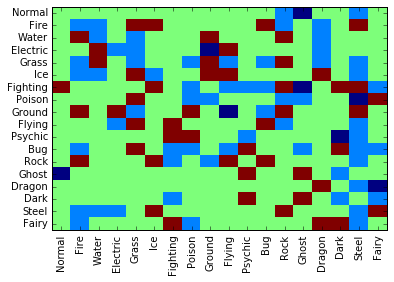

In [4]:
show_heatmap(damage_factor)

Here dark blue represents 0, light blue represents 0.5, light green is 1, and dark red(ish) is 2.

In order to choose an attack party we need information about available Pokémon. Here I entered my top 15 (by CP) Pokémon:

In [5]:
# My Pokémon
my_pokemon = read_csv("""
Pokemon      CP  Attack1 Power1  Attack2 Power2
Arcanine   1535  Dark         6  Ground      30
Arcanine   1356  Fire         7  Fire        50
Rhydon     1057  Ground       6  Bug         55
Arcanine    968  Dark         6  Fire        50
Flareon     927  Fire        10  Fire        60
Sandslash   767  Ground      12  Ground      60
Primeape    751  Fighting     6  Fighting    25
Aerodactyl  677  Dark         6  Steel       40
Sandslash   669  Steel       12  Ground      30
Golem       668  Ground      12  Rock        30
Parasect    627  Bug          6  Poison      20
Arbok       596  Poison      10  Poison      60
Machoke     584  Fighting     5  Fighting    30
Primeape    576  Fighting     5  Fighting    55
Dodrio      562  Dark        12  Flying      25
""")

You can enter your own Pokémon data instead.

And now the enemy Pokémon defending the gym I want to conquer:

In [6]:
# Enemy Pokémon defending the gym I want to attack
enemies = read_csv("""
Pokemon      CP
Magmar      402
Pidgeot     483
Snorlax     979
""")

Unfortunately the game doesn't provide information about the types of attack that the enemy Pokémon have, so I'll focus on optimizing the attack power of my own party and hope for the best defense-wise.

If you, like me, are new to the game, then chances are that you don't remember exactly the types of Pokémon. One could make an educated guess that the type of Pidgeot is Flying (which is not entirely true). Otherwise, I had to look up the types in the Internet. But having all (or rather, some of) the data in the data frames, I can now query types of enemy Pokémon with a one liner:

In [7]:
pd.concat([enemies, enemies.apply(lambda e: types.loc[e.Pokemon], axis=1)], axis=1)

,Pokemon,CP,Type1,Type2
0,Magmar,402,Fire,-
1,Pidgeot,483,Flying,Normal
2,Snorlax,979,Normal,-


Now let's build and visualize the attack advantage table against these three Pokémon types including one compound type:

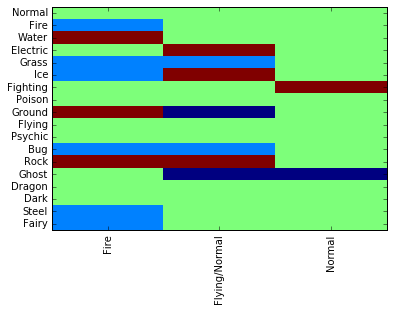

In [8]:
dfs = []
for e in enemies.itertuples():
    t = types.loc[e.Pokemon]
    factor = damage_factor[t.Type1]
    if t.Type2 != '-':
        factor = factor * damage_factor[t.Type2]
        factor.rename('{}/{}'.format(t.Type1, t.Type2), inplace=True)
    dfs.append(factor)

data = pd.concat(dfs, axis=1)
show_heatmap(data)

You can immediately see that attacks of types Grass and Ghost are not the best choice in this case. Using the Grass attack on the first two Pokémon, Magmar and Pidgeot, will half the damage. The Ghost attack is even worse with 0 damage when used on the last two Pokémon.

Previously I'd go over a few of my Pokémon and choose the ones with a suitable attack type. But now it can be automated! To this end I introduce function `estimate_damage` that returns an average damage that my given Pokémon is expected to inflict on the given enemy Pokémon. The tricky part here is that there are two types of attacks, normal and special. They are combined via the parameter `attack2_fraction` which gives the fraction of attacks that are special. Currently `attack2_fraction` is set to 0.1 but this can be adjusted.

In [9]:
# Fraction of special attacks (Attack2), e.g. 0.1 means that 10% of attacks
# are special.
attack2_fraction = 0.1

def estimate_damage(my, enemy):
    """Estimate average damage that my Pokémon inflicts on the enemy Pokémon."""
    type1, type2 = types.loc[enemy.Pokemon]
    adv1 = damage_factor.loc[my.Attack1][type1]
    adv2 = damage_factor.loc[my.Attack2][type1]
    if type2 != '-':
        adv1 *= damage_factor.loc[my.Attack1][type2]
        adv2 *= damage_factor.loc[my.Attack2][type2]
    return adv1 * my.Power1 * (1 - attack2_fraction) + \
           adv2 * my.Power2 * attack2_fraction

Now let's compute the estimated damage for all my and enemy Pokémon given earlier. Note that my Sandslash with ID 5, makes 0 estimated damage against Enemy2 which is Pidgeot. The reason is simple: both attacks of my Sandslash have type Ground which is inefficient against Flying Pokémon. This is a bit disappointing considering that the Ground attack is extremely efficient against the first enemy.

In [10]:
df = pd.concat(
    [my_pokemon.apply(lambda p: estimate_damage(p, enemies.loc[i]), axis=1)
     for i in enemies.index], axis=1)
df.rename(columns=dict((i, 'Enemy{}'.format(i + 1)) for i in enemies.index), inplace=True)
estimated_damage = pd.concat([my_pokemon[['Pokemon', 'CP']], df], axis=1)
estimated_damage

,Pokemon,CP,Enemy1,Enemy2,Enemy3
0,Arcanine,1535,11.40,5.40,8.4
1,Arcanine,1356,5.65,11.30,11.3
2,Rhydon,1057,13.55,2.75,10.9
3,Arcanine,968,7.90,10.40,10.4
4,Flareon,927,7.50,15.00,15.0
5,Sandslash,767,33.60,0.00,16.8
6,Primeape,751,7.90,7.90,15.8
7,Aerodactyl,677,7.40,9.40,9.4
8,Sandslash,669,11.40,10.80,13.8
9,Golem,668,27.60,6.00,13.8


Using the table above it's already possible to come up a good attack party, but let's go a step further and write a [mathematical optimization](https://en.wikipedia.org/wiki/Mathematical_optimization) problem that maximizes the total estimated damage. Technically it's not necessary to use optimization software in this example, because it's relatively easy to enumerate all solutions and find the best one. However, as we consider gyms of higher levels and add more Pokémon the number of combination will increase exponentially. Also it's nice to have a high-level declarative optimization model which can be easily improved and leave the heavy lifting to solvers.

For this example, I'll use the Pyomo optimization package and an open-source MIP solver called CBC connected via the AMPL solver interface.

The first version of the optimization model is very simple. First, there are two sets: `MyPokemon` containing IDs of my Pokémon and `Pos` with positions in the attack party. For simplicity, the number of positions is limited to the number of enemies right now. The remaining positions can be filled automatically and don't really matter because in my experience it rarely takes more than one Pokémon to eliminate one opponent. Then there is a binary variable `use` indexed over the two sets. `use[p, i]` is 1 iff Pokémon `p` is in position `i` in the attack party. The objective is to maximize the total estimated damage which is a sum of estimated damages computed for all Pokémon in the party. And finally two constraints ensure that the assignment of Pokémon to positions is valid.

In [11]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

model = ConcreteModel()

# IDs of my Pokémon
model.MyPokemon = RangeSet(0, len(my_pokemon.index) - 1)

# Positions in the attack party
model.Pos = RangeSet(0, len(enemies.index) - 1)

# use[p, i] is 1 iff Pokémon p is in position i in the attack party
model.use = Var(model.MyPokemon, model.Pos, domain=Binary)

model.total_damage = Objective(
    sense=maximize,
    rule=lambda m: sum(estimate_damage(my_pokemon.loc[p], enemies.loc[i]) * m.use[p, i]
                       for p in m.MyPokemon for i in m.Pos))

# At most one Pokémon can be in position i.
model.assign1 = Constraint(
    model.Pos, rule=lambda m, i: sum(m.use[p, i] for p in m.MyPokemon) <= 1)

# Use Pokémon p in at most one position.
model.assign2 = Constraint(
    model.Pos, rule=lambda m, p: sum(m.use[p, i] for i in m.Pos) <= 1)

def solve():
    """Solve the problem and return the IDs of the Pokémon in the attack party."""
    opt = SolverFactory('cbc', solver_io='nl')
    results = opt.solve(model, tee=True)
    model.solutions.load_from(results)
    print('Objective:', model.total_damage())
    return [p for i in model.Pos for p in model.MyPokemon if model.use[p, i].value != 0]

Now let's solve this problem and display the result:

In [12]:
estimated_damage.loc[solve()]

CBC 2.8.8: printingOptions=all
Objective: 68.6


,Pokemon,CP,Enemy1,Enemy2,Enemy3
5,Sandslash,767,33.6,0.0,16.8
11,Arbok,596,15.0,15.0,15.0
13,Primeape,576,10.0,10.0,20.0


The problem with this solution is that if Sandslash beats the first enemy which is very likely, it's attacks will have no effect against the second one. So let's disallow such situations by fixing appropriate variables to 0:

In [13]:
# Don't use Pokémon that are ineffective in the next attack.
for p in model.MyPokemon:
    for i in range(1, len(enemies.index)):
        if estimate_damage(my_pokemon.loc[p], enemies.loc[i]) == 0:
            model.use[p, i - 1] = 0
            model.use[p, i - 1].fixed = True

estimated_damage.loc[solve()]

CBC 2.8.8: printingOptions=all
Objective: 62.6


,Pokemon,CP,Enemy1,Enemy2,Enemy3
9,Golem,668,27.6,6.0,13.8
11,Arbok,596,15.0,15.0,15.0
13,Primeape,576,10.0,10.0,20.0


The new solution looks better but the attack party consists of Pokémon with relatively low CP. To take it into account, let's normalize the estimated damage and Pokémon CP dividing them by maximum values. Now that they are in the same range [0, 1] we can more sensibly combine the two using the `damage_weight` parameter which gives relative importance of estimated damage vs CP. The current weight of 0.6 is chosen somewhat arbitrarily to give a bit more importance to the estimated damage, but it can be easily changed.

In [14]:
max_damage = [max(estimate_damage(my_pokemon.loc[p], enemies.loc[i])
                  for p in model.MyPokemon) for i in model.Pos]
max_cp = my_pokemon['CP'].max()

# Relative weight of estimated damage vs CP
damage_weight = 0.6

def obj_coef(pokemon, pos):
    damage = estimate_damage(my_pokemon.loc[pokemon], enemies.loc[pos])
    return damage_weight * damage / max_damage[pos] + \
           (1 - damage_weight) * my_pokemon.CP[pokemon] / max_cp

model.del_component('total_damage')
model.total_damage = Objective(
    sense=maximize,
    rule=lambda m: sum(obj_coef(p, i) * m.use[p, i] for p in m.MyPokemon for i in m.Pos))

estimated_damage.loc[solve()]

CBC 2.8.8: printingOptions=all
Objective: 2.25859004188


,Pokemon,CP,Enemy1,Enemy2,Enemy3
9,Golem,668,27.6,6.0,13.8
4,Flareon,927,7.5,15.0,15.0
13,Primeape,576,10.0,10.0,20.0


Arbok has been replaced with Flareon that has higher CP in the new solution which makes sense. The solution looks completely different from what I would have chosen because I wouldn't have patience to go over all the Pokémon stats. Now it's time to go and check if it works in the field!

<blockquote><p>All models are wrong but some are useful</p>&mdash; George Box</blockquote>

There are many ways to improve the model. In particular, one can take into account Same Type Attack Bonus (STAB), the estimated damage of attack party members against more than one opponen, make `attack2_fraction` depend on the special attack type because some attacks take longer to build up power, etc.